In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import zscore
import warnings 
warnings.filterwarnings('ignore')
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
#read the csv file and convert into a dataframe
df = pd.read_csv("ICO_Data.csv")
df

,ICO,Token,Softcap,Hardcap,Start,End,Quarterstart,Duration of offering,Country,Category,ERC20,Rating,Number of experts,Bonus,Policy,Number of team members,Distributed in ICO,US restriction,Restricted countries,Accepted fiat,Major cryptocurrencies,Amount raised
0,russianminercoin,RMC,NaN,100000000.0,8/28/2017,9/27/2019,2017q3,760.0,Russia,"Cryptocurrency,BigData",0,2.4,1.0,0,0,7.0,NaN,NaN,NaN,1,1,43000000
1,remecoin,REME,NaN,141270000.0,3/15/2018,6/14/2018,2018q1,91.0,Liechtenstein,"Internet,Businessservices",1,3.2,1.0,0,kyc,21.0,NaN,1.0,"China, USA",1,1,9558576
2,emiba,EMB,15000000,21000000.0,6/1/2018,12/31/2019,2018q2,578.0,Russia,Manufacturing,1,2.6,2.0,0,kyc,9.0,0.580,NaN,NaN,1,1,7012829
3,zeon-network,ZEON,2000000,15000000.0,6/8/2018,10/8/2018,2018q2,122.0,Estonia,"Platform,Investment,Cryptocurrency,Banking,Sma...",1,3.8,1.0,0,0,7.0,0.600,1.0,USA,1,1,700000
4,worldopo,WPT,NaN,NaN,8/17/2018,3/2/2019,2018q3,197.0,Liechtenstein,"VirtualReality,SmartContract,Entertainment,Art...",1,4.5,38.0,1,kyc&whitelist,12.0,0.750,0.0,North Korea,1,1,3392000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,olympus-labs,MOT,NaN,NaN,1/14/2018,1/14/2018,2018q1,1.0,USA,Other,1,1.7,0.0,0,0,NaN,0.382,NaN,NaN,0,0,60324750
2314,trinity,TNC,NaN,20000000.0,1/14/2018,1/14/2018,2018q1,1.0,China,"Platform,Other",0,1.7,0.0,0,0,7.0,0.000,NaN,NaN,0,0,20000000
2315,chainlink,LINK,NaN,NaN,9/19/2017,9/19/2017,2017q3,1.0,USA,Platform,1,3.0,3.0,0,0,2.0,0.000,NaN,NaN,0,1,32000000
2316,algorand,0,NaN,NaN,4/12/2019,4/12/2019,2019q2,1.0,USA,Platform,0,2.2,2.0,0,0,13.0,0.000,NaN,NaN,0,0,122400000


In [4]:
#describe the object type of variables in the dataframe
df.describe(include = ['object'])

,ICO,Token,Softcap,Start,End,Quarterstart,Country,Category,Policy,Restricted countries,Amount raised
count,2318,2292,1218,2309,2311,2318,2253,2260,2318,925,2317
unique,2318,2091,513,723,750,19,107,1034,4,310,1498
top,mas-coin,0,1000000,3/1/2018,12/31/2018,2018q1,USA,Platform,0,USA,10000000
freq,1,27,108,41,39,447,292,198,1289,199,45


In [5]:
#check how many NaN variables under each column
df.isnull().sum()

ICO                          0
Token                       26
Softcap                   1100
Hardcap                    501
Start                        9
End                          7
Quarterstart                 0
Duration of offering        10
Country                     65
Category                    58
ERC20                        0
Rating                       3
Number of experts            3
Bonus                        0
Policy                       0
Number of team members     175
Distributed in ICO         480
US restriction            1394
Restricted countries      1393
Accepted fiat                0
Major cryptocurrencies       0
Amount raised                1
dtype: int64

In [9]:
#drop the specified columns as they have many missing variables and do not affect the outcome much
df = df.drop(['Number of team members','US restriction', 'Distributed in ICO', 'Restricted countries', 'Country'], axis=1)

In [10]:
#fill the missing cells under Softcap with zero
df['Softcap'] = df['Softcap'].fillna(0)

In [11]:
df['Softcap']

0              0
1              0
2       15000000
3        2000000
4              0
          ...   
2313           0
2314           0
2315           0
2316           0
2317           0
Name: Softcap, Length: 2318, dtype: object

In [15]:
#fill the missing values under Hardcap with zero
#fill the cells (#ref) with zero under Softcap
#handle the negative cells under hardcap by replacing with zero
df['Softcap'] = df['Softcap'].replace('#REF!',0)
df['Hardcap'] = df['Hardcap'].fillna(0)
df['Hardcap'] = df['Hardcap'].replace(-2147483648,0)

In [13]:
df['Softcap']

0              0
1              0
2       15000000
3        2000000
4              0
          ...   
2313           0
2314           0
2315           0
2316           0
2317           0
Name: Softcap, Length: 2318, dtype: object

In [16]:
#change the type of start and end columns and make them datetime objects
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

In [19]:
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

ICO                       0
Token                     0
Softcap                   0
Hardcap                   0
Start                     0
End                       0
Quarterstart              0
Duration of offering      0
Category                  0
ERC20                     0
Rating                    0
Number of experts         0
Bonus                     0
Policy                    0
Accepted fiat             0
Major cryptocurrencies    0
Amount raised             0
dtype: int64

In [22]:
df['Count of Category'] = df['Category'].str.count(',')+1
df['Count of Category']

0       2
1       2
2       1
3       5
4       4
       ..
2312    1
2313    1
2314    2
2315    1
2316    1
Name: Count of Category, Length: 2221, dtype: int64

In [54]:
#change the type of the policy column
df['Policy'] = df['Policy'].replace(['kyc', 'kyc&whitelist', 'whitelist'], 1)
df['Policy'] = df['Policy'].astype(float).astype(int)
df['Amount raised'] = df['Amount raised'].astype(int).astype(float)

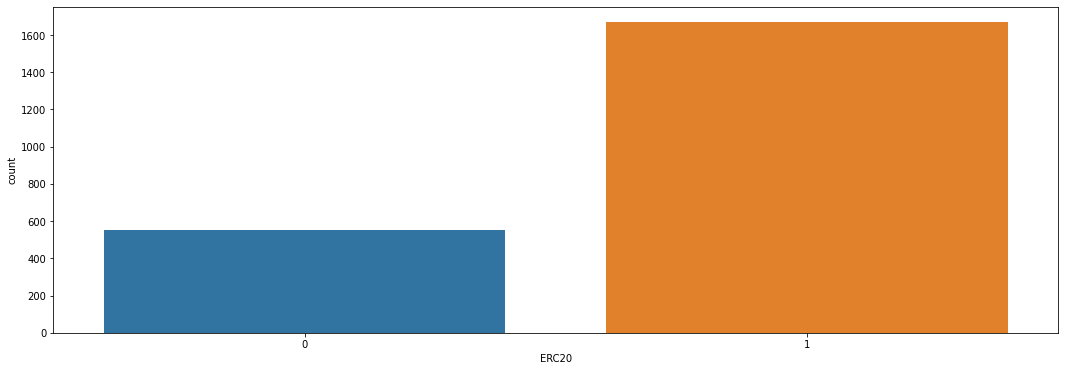

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (18,6)
sns.countplot(x=df['ERC20'])

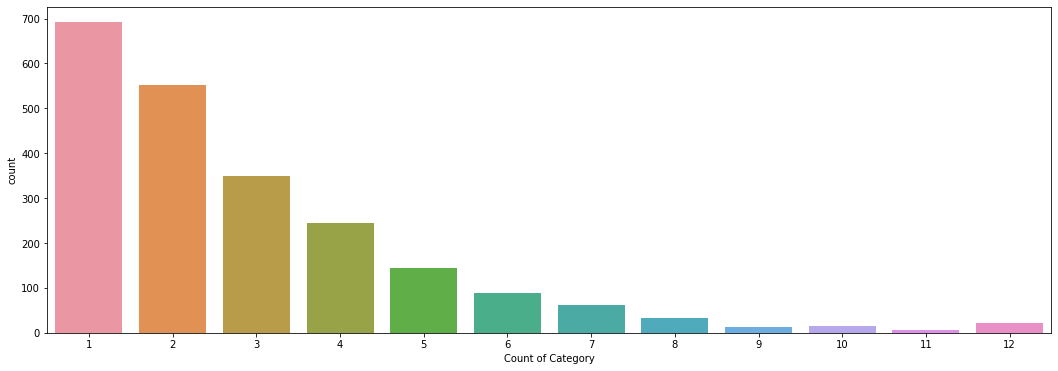

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (18,6)
sns.countplot(x=df['Count of Category'])

In [29]:
df.groupby('Bonus')['Rating'].mean()

Bonus
0    2.960128
1    3.383951
Name: Rating, dtype: float64

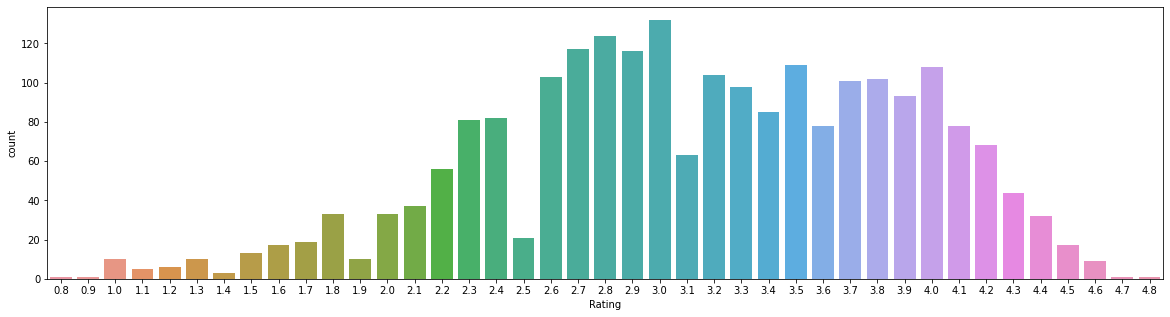

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,5)
sns.countplot(x=df['Rating'])

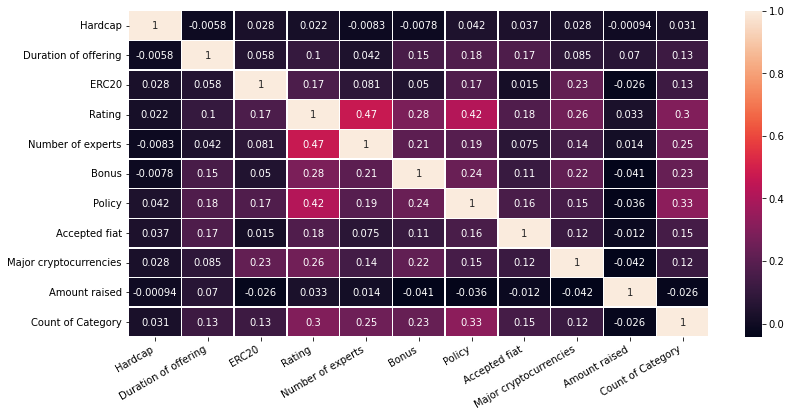

In [36]:
corrmat = df.corr()
plt.figure(figsize=(13, 6))
sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

In [47]:
df.head()

,ICO,Token,Softcap,Hardcap,Start,End,Quarterstart,Duration of offering,Category,ERC20,Rating,Number of experts,Bonus,Policy,Accepted fiat,Major cryptocurrencies,Amount raised,Count of Category
0,russianminercoin,RMC,0,100000000.0,2017-08-28,2019-09-27,2017q3,760.0,"Cryptocurrency,BigData",0,2.4,1.0,0,0,1,1,43000000,2
1,remecoin,REME,0,141270000.0,2018-03-15,2018-06-14,2018q1,91.0,"Internet,Businessservices",1,3.2,1.0,0,1,1,1,9558576,2
2,emiba,EMB,15000000,21000000.0,2018-06-01,2019-12-31,2018q2,578.0,Manufacturing,1,2.6,2.0,0,1,1,1,7012829,1
3,zeon-network,ZEON,2000000,15000000.0,2018-06-08,2018-10-08,2018q2,122.0,"Platform,Investment,Cryptocurrency,Banking,Sma...",1,3.8,1.0,0,0,1,1,700000,5
4,worldopo,WPT,0,0.0,2018-08-17,2019-03-02,2018q3,197.0,"VirtualReality,SmartContract,Entertainment,Art...",1,4.5,38.0,1,1,1,1,3392000,4


In [87]:
df['Softcap'] = df['Softcap'].fillna(0)
df['Softcap'] = df['Softcap'].replace('#REF!',0)
df['Softcap'] = df['Softcap'].astype(float).astype(int)

In [90]:
success=list(range(len(df["Amount raised"])))
for i in range(len(df["Amount raised"])):
    if df.iloc[i, 2]> 0 or df.iloc[i, 18] >= 500000:
        success[i] = 1
    else:
        success[i] = 0

In [91]:
df['is_successful'] = success
df["is_successful"] = df["is_successful"].astype("int64")
df["is_successful"].value_counts()

1    1164
0    1057
Name: is_successful, dtype: int64

In [93]:
logreg_df = df.drop(["ICO","Token","Start","End","Quarterstart","Category"],axis=1)
logreg_df.head()

,Softcap,Hardcap,Duration of offering,ERC20,Rating,Number of experts,Bonus,Policy,Accepted fiat,Major cryptocurrencies,Amount raised,Count of Category,is_successful
0,0,100000000.0,760.0,0,2.4,1.0,0,0,1,1,43000000.0,2,0
1,0,141270000.0,91.0,1,3.2,1.0,0,1,1,1,9558576.0,2,0
2,15000000,21000000.0,578.0,1,2.6,2.0,0,1,1,1,7012829.0,1,1
3,2000000,15000000.0,122.0,1,3.8,1.0,0,0,1,1,700000.0,5,1
4,0,0.0,197.0,1,4.5,38.0,1,1,1,1,3392000.0,4,0


In [96]:
logreg_dummy = pd.get_dummies(logreg_df,drop_first=True)

In [97]:
logreg_df_new = logreg_dummy.drop("Softcap",axis=1)
logreg_df_new.head()

,Hardcap,Duration of offering,ERC20,Rating,Number of experts,Bonus,Policy,Accepted fiat,Major cryptocurrencies,Amount raised,Count of Category,is_successful
0,100000000.0,760.0,0,2.4,1.0,0,0,1,1,43000000.0,2,0
1,141270000.0,91.0,1,3.2,1.0,0,1,1,1,9558576.0,2,0
2,21000000.0,578.0,1,2.6,2.0,0,1,1,1,7012829.0,1,1
3,15000000.0,122.0,1,3.8,1.0,0,0,1,1,700000.0,5,1
4,0.0,197.0,1,4.5,38.0,1,1,1,1,3392000.0,4,0


In [98]:
logreg_df_new["is_successful"].value_counts

<bound method IndexOpsMixin.value_counts of 0       0
1       0
2       1
3       1
4       0
       ..
2312    0
2313    0
2314    0
2315    0
2316    0
Name: is_successful, Length: 2221, dtype: int64>

In [99]:
X_df = logreg_df_new.drop("is_successful",axis=1)
X = sm.add_constant(X_df)
y = logreg_df_new["is_successful"]

In [100]:
train_X, test_X, train_y, test_y = train_test_split(X,y,train_size=0.7,random_state=6)

In [101]:
logreg_model = sm.Logit(train_y,train_X).fit()
logreg_model.summary2()

Optimization terminated successfully.
         Current function value: 0.584869
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.153     
Dependent Variable:    is_successful     AIC:               1841.7734 
Date:                  2022-01-12 09:00  BIC:               1905.9565 
No. Observations:      1554              Log-Likelihood:    -908.89   
Df Model:              11                LL-Null:           -1073.7   
Df Residuals:          1542              LLR p-value:       5.0764e-64
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        8.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
const                  -2.7931   0.3222 -8.6688 0.0000 -3.4246 -2.1616
Hardcap                 0.0000   0.0000  1.4647 0.1430 -0.0000  0.0000
Duration of offering    0.0052   0.0012  4.3043 0.0000  0.0028  0.0075
ERC20                   0.1766   0.1396  1.2652 0.2058 -0.0970  0.4501
Rating                  0.4295   0.0995  4.3171 0.0000  0.2345  0.6245
Number of experts       0.0030   0.0080  0.3708 0.7108 -0.0127  0.0186
Bonus                   0.6771   0.1203  5.6310 0.0000  0.4414  0.9128
Policy                  0.7604   0.1286  5.9112 0.0000  0.5083  1.0125
Accepted fiat           0.0870   0.1846  0.4716 0.6372 -0.2747  0.4488
Major cryptocurrencies  0.5742   0.1841  3.1191 0.0018  0.2134  0.9350
Amount raised          -0.0000   0.0000 -2.4410 0.0146 -0.0000 -0.0000
Count of Category       0.0327   0.0302  1.0818 0.2793 -0.0265  0.0919
======================================================================

"""

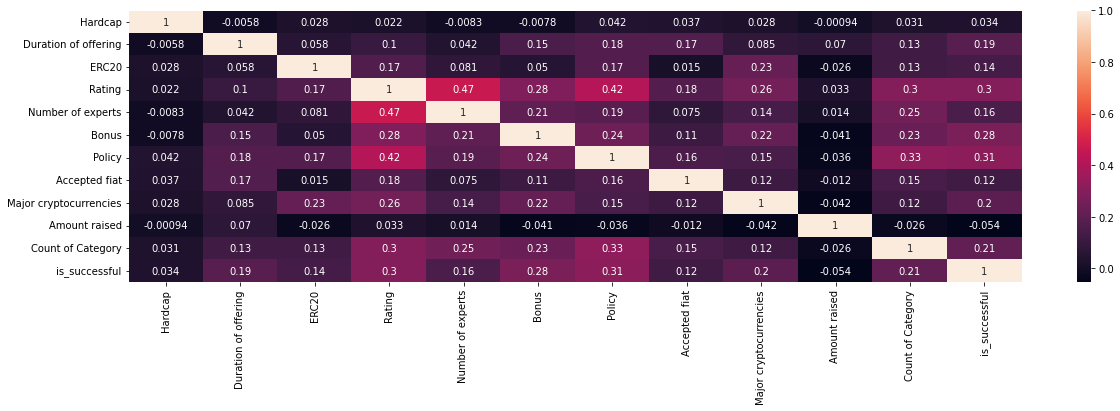

In [102]:
sn.heatmap(logreg_df_new.corr(), annot = True)

In [104]:
def backward_elimination(model, y, X, features):
    while True:
        if max(model.pvalues[features]) > 0.05:
            drop_variable = model.pvalues[model.pvalues == max(model.pvalues[features])]
            print("Dropping " + drop_variable.index[0] + " and running regression again because pvalue is: " + str(drop_variable[0]))
            X = X.drop(columns = [drop_variable.index[0]])
            features = features.drop(drop_variable.index[0])
            model= sm.OLS(y, X).fit()
        else:
            print("All p values less than 0.05")
            return features
            break;
        
significant_Features = backward_elimination(logreg_model, train_y, train_X, X_df.columns)
print(significant_Features)

train_X = sm.add_constant(train_X[significant_Features])
test_X = sm.add_constant(test_X[significant_Features])
log_model2 = sm.Logit(train_y, train_X).fit()
log_model2.summary2()

Dropping Number of experts and running regression again because pvalue is: 0.7107733923618879
Dropping Accepted fiat and running regression again because pvalue is: 0.7231159814079164
Dropping Count of Category and running regression again because pvalue is: 0.22096705594980542
Dropping ERC20 and running regression again because pvalue is: 0.15498791080742028
Dropping Hardcap and running regression again because pvalue is: 0.09688194611734625
All p values less than 0.05
Index(['Duration of offering', 'Rating', 'Bonus', 'Policy',
       'Major cryptocurrencies', 'Amount raised'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.587225
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.150     
Dependent Variable:    is_successful     AIC:               1839.0949 
Date:                  2022-01-12 09:01  BIC:               1876.5351 
No. Observations:      1554              Log-Likelihood:    -912.55   
Df Model:              6                 LL-Null:           -1073.7   
Df Residuals:          1547              LLR p-value:       1.3960e-66
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        7.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
const                  -2.7461   0.2939 -9.3446 0.0000 -3.3221 -2.1701
Duration of offering    0.0053   0.0012  4.4874 0.0000  0.0030  0.0077
Rating                  0.4691   0.0896  5.2346 0.0000  0.2934  0.6447
Bonus                   0.6829   0.1188  5.7487 0.0000  0.4501  0.9158
Policy                  0.8179   0.1241  6.5922 0.0000  0.5747  1.0611
Major cryptocurrencies  0.6372   0.1806  3.5289 0.0004  0.2833  0.9912
Amount raised          -0.0000   0.0000 -2.4358 0.0149 -0.0000 -0.0000
======================================================================

"""

In [115]:
y_pred_df = pd.DataFrame( { "actual": test_y, 
                            "predicted_prob": log_model2.predict( 
                        sm.add_constant(test_X[significant_Features] ) ) } )
y_pred_df['predicted1'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.5 else 0)

y_pred_df.head()

,actual,predicted_prob,predicted1
2197,0,0.139351,0
1888,0,0.330883,0
170,1,0.545478,1
1045,0,0.593733,1
1982,1,0.817664,1


In [128]:
def draw_cm(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted, [1,0])
    tp = cm[0][0]
    fp = cm[1][0]
    fn = cm[0][1]
    tn = cm[1][1]
    print('True positive = ', tp)
    print('False positive = ' , fp)
    print('False negative = ' , fn)
    print('True negative = ', tn)
    print('Accuracy = ', (tp+tn)/(tp+tn+fn+fp))
    print('True positive rate = ', tp/(tp+fn))   
    print('True negative rate = ', tn/(tn+fp))
    print('False positive rate = ', fp/(tn+fp))
    print('False negative rate = ', fn/(fn+tp))
    
    sn.heatmap(cm, annot=True,  fmt='.2f', 
               xticklabels = ["Successful", "Not Successful"] , 
               yticklabels = ["Successful", "Not Successful"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [117]:
def draw_roc( actual, probs ):
    fpr, \
    tpr, \
    thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(8, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

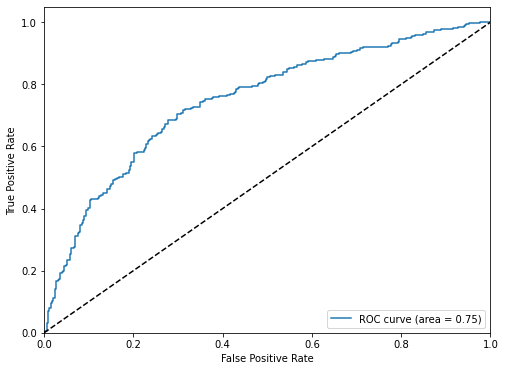

In [119]:
fpr, tpr, thresholds = draw_roc(y_pred_df.actual, y_pred_df.predicted_prob)

In [120]:
auc_score = metrics.roc_auc_score( y_pred_df.actual, y_pred_df.predicted_prob)
round(float(auc_score),2)

0.75

In [121]:
tpr_fpr = pd.DataFrame( { 'tpr': tpr, 
                         'fpr': fpr, 
                         'thresholds': thresholds } )

tpr_fpr['diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values( 'diff', ascending = False )[0:5]

,tpr,fpr,thresholds,diff
321,0.683582,0.277108,0.515738,0.406474
335,0.704478,0.298193,0.503103,0.406285
343,0.716418,0.310241,0.495050,0.406177
320,0.680597,0.277108,0.516094,0.403489
322,0.683582,0.280120,0.515536,0.403462


In [122]:
y_pred_df['predicted2'] = y_pred_df.predicted_prob.map( 
                                lambda x: 1 if x > 0.470164 else 0)
y_pred_df.head()

,actual,predicted_prob,predicted1,predicted2
2197,0,0.139351,0,0
1888,0,0.330883,0,0
170,1,0.545478,1,1
1045,0,0.593733,1,1
1982,1,0.817664,1,1


In [124]:
def get_total_cost( actual, predicted, cost_FPs, cost_FNs ):
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    cm_mat = np.array( cm )
    return cm_mat[0,1] * cost_FNs + cm_mat[1,0] * cost_FPs

In [125]:
cost_df = pd.DataFrame( columns = ['prob', 'cost'])

In [129]:
cost_df.sort_values( 'cost', ascending = True )[0:5]

,prob,cost


In [135]:
data_df_return = pd.read_csv("ICO_Return.csv")


In [136]:
data_df_merged = pd.merge(df, data_df_return, on = 'ICO')

In [137]:
data_df_merged = data_df_merged.dropna()

In [138]:
data_df_merged = data_df_merged[data_df_merged['Amount raised'] >= 0]

In [139]:
data_df_merged['Ratio of Softcap/Amount Raised'] = data_df_merged['Amount raised']/data_df_merged['Softcap']

In [140]:
data_df_merged['Ratio of Softcap/Amount Raised'] = data_df_merged['Ratio of Softcap/Amount Raised'].replace([np.inf, -np.inf], 0)

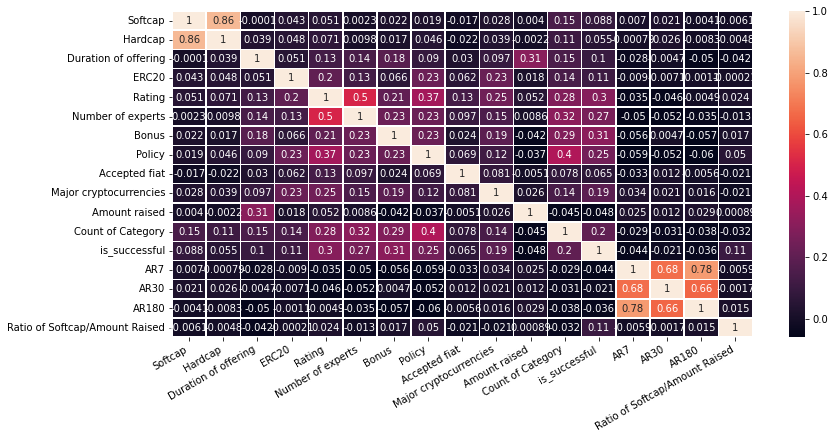

In [141]:
corrmat_merged = data_df_merged.corr()
plt.figure(figsize=(13, 6))
sns.heatmap(corrmat_merged, vmax=1, annot=True, linewidths=.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

In [144]:
Y1 = data_df_merged[['AR7']]
X1 = data_df_merged.drop(['ICO','Category','Start','End','AR7','AR30','AR180',"Token"],axis=1)

In [143]:
from sklearn.linear_model import LinearRegression

In [146]:
X1 =pd.get_dummies(X1, drop_first=True)
X1_df = sm.add_constant(X1)
X1_df.head()

,const,Softcap,Hardcap,Duration of offering,ERC20,Rating,Number of experts,Bonus,Policy,Accepted fiat,Major cryptocurrencies,Amount raised,Count of Category,is_successful,Ratio of Softcap/Amount Raised,Quarterstart_2016q1,Quarterstart_2016q2,Quarterstart_2016q3,Quarterstart_2016q4,Quarterstart_2017q1,Quarterstart_2017q2,Quarterstart_2017q3,Quarterstart_2017q4,Quarterstart_2018q1,Quarterstart_2018q2,Quarterstart_2018q3,Quarterstart_2018q4,Quarterstart_2019q1,Quarterstart_2019q2,Quarterstart_2019q3
0,1.0,0,100000000.0,396.0,1,3.8,27.0,0,1,0,1,2.360600e+07,5,0,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1.0,0,114357673.8,364.0,1,4.3,15.0,1,1,0,1,7.500000e+04,2,0,0.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1.0,0,0.0,344.0,1,4.1,9.0,0,0,0,1,4.197956e+09,1,0,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,1.0,3488800,34888000.0,214.0,1,4.1,19.0,1,1,0,1,1.371565e+06,6,1,0.393134,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,1.0,1000000,52600000.0,189.0,0,2.8,2.0,0,0,0,1,1.212952e+07,3,1,12.129522,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [148]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split( X1_df, Y1, test_size = 0.9, random_state = 42)

In [149]:
data_model = sm.OLS(train_Y, train_X).fit()
data_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                   OLS                  Adj. R-squared:         0.589   
Dependent Variable:      AR7                  AIC:                    109.2341
Date:                    2022-01-12 09:48     BIC:                    157.4041
No. Observations:        60                   Log-Likelihood:         -31.617 
Df Model:                22                   F-statistic:            4.836   
Df Residuals:            37                   Prob (F-statistic):     1.30e-05
R-squared:               0.742                Scale:                  0.27238 
------------------------------------------------------------------------------
                                Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
const                          -0.0036   0.4668 -0.0077 0.9939 -0.9493  0.9421
Softcap                        -0.0000   0.0000 -0.4961 0.6228 -0.0000  0.0000
Hardcap                        -0.0000   0.0000 -0.6448 0.5230 -0.0000  0.0000
Duration of offering           -0.0003   0.0016 -0.2173 0.8292 -0.0035  0.0028
ERC20                           0.3332   0.2013  1.6548 0.1064 -0.0748  0.7411
Rating                          0.0243   0.1547  0.1574 0.8758 -0.2890  0.3377
Number of experts              -0.0011   0.0076 -0.1503 0.8814 -0.0165  0.0142
Bonus                          -0.0696   0.1864 -0.3734 0.7110 -0.4474  0.3082
Policy                          0.1216   0.2387  0.5094 0.6135 -0.3620  0.6052
Accepted fiat                  -0.1717   0.2721 -0.6310 0.5319 -0.7230  0.3796
Major cryptocurrencies         -0.0407   0.2067 -0.1969 0.8450 -0.4596  0.3782
Amount raised                   0.0000   0.0000  0.0336 0.9733 -0.0000  0.0000
Count of Category               0.0497   0.0632  0.7860 0.4368 -0.0784  0.1777
is_successful                   0.1505   0.2143  0.7024 0.4868 -0.2837  0.5848
Ratio of Softcap/Amount Raised  0.0052   0.0013  3.9360 0.0004  0.0025  0.0078
Quarterstart_2016q1             0.0000   0.0000  6.5230 0.0000  0.0000  0.0000
Quarterstart_2016q2            -0.3048   0.5861 -0.5200 0.6062 -1.4923  0.8828
Quarterstart_2016q3            -0.0000   0.0000 -3.0318 0.0044 -0.0000 -0.0000
Quarterstart_2016q4            -0.0000   0.0000 -2.0269 0.0499 -0.0000 -0.0000
Quarterstart_2017q1            -0.0000   0.0000 -3.8598 0.0004 -0.0000 -0.0000
Quarterstart_2017q2            -0.0585   0.2690 -0.2175 0.8290 -0.6036  0.4866
Quarterstart_2017q3            -0.6713   0.2585 -2.5970 0.0134 -1.1951 -0.1475
Quarterstart_2017q4            -0.4386   0.2553 -1.7183 0.0941 -0.9559  0.0786
Quarterstart_2018q1            -0.6491   0.1868 -3.4739 0.0013 -1.0277 -0.2705
Quarterstart_2018q2            -0.1554   0.1966 -0.7905 0.4343 -0.5537  0.2429
Quarterstart_2018q3            -1.0141   0.5688 -1.7827 0.0828 -2.1667  0.1385
Quarterstart_2018q4            -0.6868   0.4029 -1.7047 0.0966 -1.5031  0.1295
Quarterstart_2019q1             3.9750   0.5539  7.1768 0.0000  2.8527  5.0972
Quarterstart_2019q2             0.0000   0.0000     nan    nan  0.0000  0.0000
Quarterstart_2019q3             0.0000   0.0000     nan    nan  0.0000  0.0000
------------------------------------------------------------------------------
Omnibus:              39.206       Durbin-Watson:          1.781              
Prob(Omnibus):        0.000        Jarque-Bera (JB):       160.267            
Skew:                 1.729        Prob(JB):               0.000              
Kurtosis:             10.222       Condition No.:          2010655434781416960
==============================================================================
* The condition number is large (2e+18). This might indicate
strong multicollinearity or other numerical problems.
"""